<a href="https://colab.research.google.com/github/epadam/CNN_AV1/blob/master/training/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, sys, pickle, json
from os import makedirs
from os.path import exists, join
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [49]:
import urllib.request
#request dataset for 16, 32, 64 
urllib.request.urlretrieve('http://download2269.mediafire.com/n3loxvto5yag/txp7zspyh5njd7o/merge_aecf_samples_64_intra_uint8.txt', 'undersampling_pixel_64.txt')
urllib.request.urlretrieve('http://download2268.mediafire.com/pmniu1lnafkg/6uxaiphdd61m10n/merge_aecf_labels_64_intra.txt', 'undersampling_labels_64.txt')
urllib.request.urlretrieve('http://download1525.mediafire.com/xakscozs0qxg/n6y8a8negm2yzhe/merge_aecf_qps_64_intra.txt', 'undersampling_QPs_64.txt')
os.listdir()

['.config',
 'ash_qps_16_intra.txt',
 'undersampling_QPs_64.txt',
 'undersampling_pixel_64.txt',
 'ash_labels_16_intra.txt',
 'ash_qps_32_intra.txt',
 'undersampling_labels_64.txt',
 'sample_data']

In [0]:
batch_size = 128
num_classes = 10
block_size = 64
NUM_CHANNELS = 1
epochs = 10

In [69]:
sample_file = 'undersampling_pixel_64.txt'
label_file = 'undersampling_labels_64.txt'
qp_file = 'undersampling_QPs_64.txt'

with open(sample_file, 'rb') as f:
    pixels = f.read()
    raw = np.frombuffer(pixels, dtype = np.uint8)
    print(np.shape(raw))
    raw = np.reshape(raw, [-1, block_size, block_size, NUM_CHANNELS])
    print(np.shape(raw))


with open(label_file, 'r') as f_single_label:
    single_label = f_single_label.read()    
    single_label =np.fromstring (single_label, dtype=np.uint8 ,sep=' ')
    single_label = np.reshape(single_label, [-1])
    single_label = keras.utils.to_categorical(single_label, num_classes)
    print(np.shape(single_label))


with open(qp_file, 'r') as f_qp:
    qps = f_qp.read()
    qps =np.fromstring (qps, dtype=np.uint8, sep=' ')
    qps = np.reshape(qps, [-1,1])
    print(np.shape(qps)) 


(18636800,)
(4550, 64, 64, 1)
(4550, 10)
(4550, 1)


In [0]:
# check how the samples look like
image = np.reshape(raw, [-1, block_size, block_size])
for i in range(10):
	print('partition=',single_label[i], 'QP=',qps[i,0])
	plt.imshow(image[i], cmap='gray')
	plt.colorbar()
	plt.show()

In [0]:
from tensorflow.keras import optimizers, backend
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Concatenate, Conv2D, MaxPooling2D, Lambda, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

In [0]:
def sub_mean(x):
    x = x/255
    x = x - backend.mean(x)   
    return x


def net():

    data = Input(shape=(block_size,block_size,NUM_CHANNELS))

    data_norm = Lambda(sub_mean)(data)

    conv1 = Conv2D(16, (4, 4), strides =(4,4),padding='valid', activation='relu')(data_norm)
    conv1_dropout = Dropout(rate=0.7)(conv1)
    #conv1_Norm = BatchNormalization()(conv1)

    conv2 = Conv2D(24, (2, 2), strides =(2,2), activation='relu', padding='valid')(conv1_dropout)
    conv2_dropout = Dropout(rate=0.7)(conv2)
    #conv2_Norm = BatchNormalization()(conv2)
    flat2 = Flatten()(conv2_dropout)

    conv3 = Conv2D(32, (2, 2), strides =(2,2), activation='relu', padding='valid')(conv2_dropout)
    conv3_dropout = Dropout(rate=0.7)(conv3)
    #conv3_Norm = BatchNormalization()(conv3)
    flat3 = Flatten()(conv3_dropout)

    qp = Input(shape=(1,))
    qp_n = Lambda(lambda x: x/255)(qp)

    concat = Concatenate(axis=1)([flat2, flat3, qp_n])

    
    fc1 = Dense(64, activation='relu')(concat)
    fc1_dropout = Dropout(rate=0.7)(fc1)
    fc1_qp = Concatenate(axis=1)([fc1_dropout, qp_n])

    fc2 = Dense(48, activation='relu')(fc1_qp)
    fc2_dropout = Dropout(rate=0.7)(fc2)
    fc2_qp = Concatenate(axis=1)([fc2_dropout, qp_n])

    output = Dense(num_classes, activation='softmax')(fc2_qp)

    model = Model(inputs=[data,qp], outputs=output)

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])

    #plot_model(model, to_file='cnn_model.png', show_shapes=1)
    
    return model

In [72]:
model = net()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 64, 64, 1)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 16, 16, 16)   272         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 16, 16, 16)   0           conv2d_6[0][0]                   
____________________________________________________________________________________________

In [73]:
history = model.fit([raw, qps], single_label, validation_split=0.1, batch_size=batch_size, epochs=epochs, verbose=1)


Train on 4095 samples, validate on 455 samples
Epoch 1/10
4095/4095 [==============================] - 2s 504us/sample - loss: 2.3153 - acc: 0.0984 - val_loss: 2.3010 - val_acc: 0.1099
Epoch 2/10
4095/4095 [==============================] - 1s 341us/sample - loss: 2.3056 - acc: 0.1021 - val_loss: 2.3011 - val_acc: 0.1077
Epoch 3/10
4095/4095 [==============================] - 1s 317us/sample - loss: 2.3050 - acc: 0.1038 - val_loss: 2.3009 - val_acc: 0.1143
Epoch 4/10
4095/4095 [==============================] - 1s 308us/sample - loss: 2.3043 - acc: 0.1023 - val_loss: 2.3010 - val_acc: 0.1253
Epoch 5/10
4095/4095 [==============================] - 1s 315us/sample - loss: 2.3017 - acc: 0.1079 - val_loss: 2.3005 - val_acc: 0.1319
Epoch 6/10
4095/4095 [==============================] - 1s 329us/sample - loss: 2.3037 - acc: 0.0984 - val_loss: 2.3006 - val_acc: 0.1275
Epoch 7/10
4095/4095 [==============================] - 1s 314us/sample - loss: 2.3009 - acc: 0.1057 - val_loss: 2.2994 - val

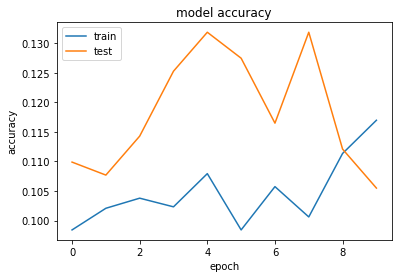

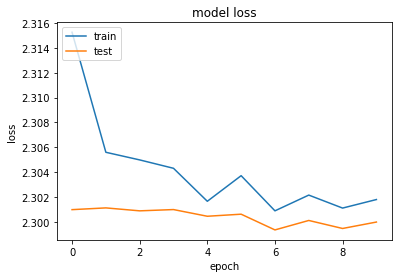

In [75]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()